In [190]:
import numpy as numpy
import scipy.io
import skimage.feature
import matplotlib
import matplotlib.pyplot as pyplot
import matplotlib.animation as animation
from IPython.display import Image

#from tempfile import NamedTemporaryFile
#from IPython.display import HTML
from moviepy.editor import *

print (matplotlib.__version__)

#pyplot.switch_backend('tkAgg')
#pyplot.switch_backend('Qt4Agg')
%matplotlib inline
#%pylab inline


1.5.1


In [191]:
class Point(object):
    
    def __init__(self, prediction, covariance):
        self.x_position = numpy.asscalar(prediction[0])
        self.y_position = numpy.asscalar(prediction[1])
        self.x_velocity = numpy.asscalar(prediction[2])
        self.y_velocity = numpy.asscalar(prediction[3])
        self.x_acceleration = numpy.asscalar(prediction[4])
        self.y_acceleration = numpy.asscalar(prediction[5])
        self.covariance_matrix = covariance
        
        

In [192]:
class KalmanFilter(object):
    
    
    def __init__(self, X_initial_state_vector):
        
        self.mu_current_vector = None
        self.COV_current_matrix = None
        
        self.mu_previous_vector = None
        self.COV_previous_matrix = None
        
        self.mu_predicted_vector = None
        self.COV_predicted_matrix = None
        
        self.y_predicted_vector = None
        self.y_observation_vector = None
        
        self.K_kalman_gain_matrix = None
        self.R_sensor_noise_matrix = None
        self.H_matrix = None
        self.I_identity_matrix = None
        
        self.u_control_vector = None
        self.A_matrix = None
        self.B_matrix = None
        self.w_state_noise_vector = None
        self.Q_process_noise_matrix = None
    
        self.z_observation_noise_vector = None
        self.C_matrix = None
        return
    
    
    def Get_Predictions(self, observations):
        predictions = list()
        for observation in observations:
            observation_column = numpy.atleast_2d(observation).T
            prediction = self.Get_Next_Prediction(observation_column)
            predictions.append(prediction)
        return predictions
    
    
    def Get_Next_Prediction(self, y_observation_vector):
        self.Update_Previous_States()
        self.Update_Predicted_States()
        self.Update_Kalman_Gain()
        self.Update_Observation_State(y_observation_vector)
        self.Update_Predicted_State()
        self.Update_Current_States()
        point = Point(self.mu_current_vector, self.COV_current_matrix)
        return point
    
    
    # mu previous is a 6 x 1 vector
    # COV previous is a 6 x 6 matrix
    def Update_Previous_States(self):
        self.mu_previous_vector = self.mu_current_vector
        self.COV_previous_matrix = self.COV_current_matrix
        
        #print "mu_previous_vector 6 x 1 " + str(self.mu_previous_vector) 
        #print "COV_previous_matrix 6 x 6 " + str(self.COV_previous_matrix) 
        return
    
    # mu predicted is a 6 x 1 vector
    # COV predicted is a 6 x 6 matrix
    def Update_Predicted_States(self):
        Amu = numpy.dot(self.A_matrix, self.mu_previous_vector)
        Bu = numpy.dot(self.B_matrix, self.u_control_vector)
        w = self.w_state_noise_vector
        self.mu_predicted_vector = Amu + Bu + w
        
        ACOV = numpy.dot(self.A_matrix, self.COV_previous_matrix)
        ACOVA_t = numpy.dot(ACOV, self.A_matrix.T)
        Q = self.Q_process_noise_matrix
        self.COV_predicted_matrix = ACOVA_t + Q 
        
        #print "mu_predicted_vector 6 x 1 " + str(self.mu_predicted_vector) 
        #print "COV_predicted_matrix 6 x 6 " + str(self.COV_predicted_matrix)
        return
    
    
    # y observation is a 2 x 1 vector
    def Update_Observation_State(self, y_observation_vector):
        Cy = numpy.dot(self.C_matrix, y_observation_vector)
        z = self.z_observation_noise_vector
        self.y_observation_vector = Cy + z
        
        #print "y_observation_vector 2 x 1 " + str(self.y_observation_vector)
        return
    
    
    # y predicted is a 2 x 1 vector
    def Update_Predicted_State(self):
        HAmu = numpy.dot(self.H_matrix, self.mu_predicted_vector)
        self.y_predicted_vector = HAmu
        
        #print "y_predicted_vector 2 x 1 " + str(self.y_predicted_vector)
        return 
    
    
    # K is a 6 x 2 matrix
    def Update_Kalman_Gain(self):
        # first_matrix is a 6 x 2 matrix
        first_matrix = numpy.dot(self.COV_predicted_matrix, self.H_matrix.T) 
        
        # HCOV is a 2 x 6 matrix
        HCOV = numpy.dot(self.H_matrix, self.COV_predicted_matrix)
        # HCOVH_t is a 2 x 2 matrix
        HCOVH_t = numpy.dot(HCOV, self.H_matrix.T)
        # R is a 2 x 2 matrix
        R = self.R_sensor_noise_matrix
        # second_matrix is a 2 x 2 
        second_matrix = numpy.linalg.pinv(HCOVH_t + R)
        
        # K is a 6 x 2 matrix
        self.K_kalman_gain_matrix = numpy.dot(first_matrix, second_matrix)
        
        #print "K_kalman_gain_matrix 6 x 2 " + str(self.K_kalman_gain_matrix)
        return 
    
    
    # mu current is a 6 x 1 vector
    # COV current is a 6 x 6 matrix
    def Update_Current_States(self):
        # y_minus_y is a 2 x 1 vector
        y_minus_y = self.y_observation_vector - self.y_predicted_vector
        # Ky is a 6 x 1 vector
        Ky = numpy.dot(self.K_kalman_gain_matrix, y_minus_y)
        # mu predicted is a 6 x 1 vector
        mu = self.mu_predicted_vector
        # mu current is a 6 x 1 vector
        self.mu_current_vector = mu + Ky
        
        # KH is a 6 x 6 matrix
        KH = numpy.dot(self.K_kalman_gain_matrix, self.H_matrix)
        # I is a 6 x 6 matrix
        I = self.I_identity_matrix
        # COV previous is 6 x 6 matrix
        COV = self.COV_predicted_matrix
        # COV current is a 6 x 6 matrix
        self.COV_current_matrix = numpy.dot(I - KH, COV)
        
        #print "mu_current_vector 6 x 1 " + str(self.mu_current_vector)
        #print "COV_current_matrix 6 x 6 " + str(self.COV_current_matrix)
        return
        
                

In [193]:
class PositionTracker(KalmanFilter):
    
    def __init__(self, mu_initial_state, COV_initial_state):
        # These are 6 x 1 vectors
        self.mu_current_vector = mu_initial_state
        self.mu_previous_vector = None
        self.mu_predicted_vector = None
        self.u_control_vector = numpy.zeros(shape=(6,1))
        self.w_state_noise_vector = numpy.zeros(shape=(6,1))
        
        # These are 6 x 6 matrixes
        self.COV_current_matrix = COV_initial_state
        self.COV_previous_matrix = None
        self.COV_predicted_matrix = None
        self.A_matrix = self.Get_A_Matrix()
        self.B_matrix = numpy.eye(6)
        self.I_identity_matrix = numpy.eye(6)
        self.Q_process_noise_matrix = self.Get_Q_Matrix()
        
        # These are 2 x 1 vectors
        self.y_predicted_vector = None
        self.y_observation_vector = None
        self.z_observation_noise_vector = numpy.zeros(shape=(2,1))
        
        # These are 6 x 2 matrixes
        self.K_kalman_gain_matrix = None
        
        # These are 2 x 2 matrixes
        self.R_sensor_noise_matrix = self.Get_R_Matrix()
        self.C_matrix = numpy.eye(2)
        
        # These are 2 x 6 matrixes
        self.H_matrix = self.Get_H_Matrix()
        
        return
 

    def Get_A_Matrix(self):
        # our dynamics are described by random accelerations
        A = numpy.asarray([
            [ 1, 0, 1, 0, 0.5, 0 ],
            [ 0, 1, 0, 1, 0, 0.5 ],
            [ 0, 0, 1, 0, 1, 0 ],
            [ 0, 0, 0, 1, 0, 1 ],
            [ 0, 0, 0, 0, 1, 0 ],
            [ 0, 0, 0, 0, 0, 1 ] ])
        return A
    
    def Get_H_Matrix(self):
        # our observations are only the position components
        H = numpy.asarray([
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0]])
        return H
    
    def Get_Q_Matrix(self):
        # our dynamics noise tries to force random accelerations to account
        # for most of the dynamics uncertainty
        Q = 1e-2 * numpy.eye( 6 )
        Q[4,4] = 0.5  # variance of accelerations is higher
        Q[5,5] = 0.5
        return Q
    
    def Get_R_Matrix(self):
        # our observation noise
        R = 20 * numpy.eye( 2 )
        return R
    
    

In [194]:
class Main(object):
    
    VIDEO_TAG = """<video controls>
                    <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
                     Your browser does not support the video tag.
                    </video>"""
    
    def __init__(self, observations):
        self.observations = observations
        mu_initial_state = numpy.zeros(( 6, 1 ))
        COV_initial_state = numpy.eye( 6 )
        self.tracker = PositionTracker(mu_initial_state, COV_initial_state)
        return
    
    
    def Run(self):
        predictions = self.tracker.Get_Predictions(self.observations)
        return predictions
    
    
    # This function plots the data points, and the current state of the gaussian clusters.
    def Plot(self, tittle, noisy_points, prediction_points, xLim, yLim, true_points = None): 

        figure = pyplot.figure()
        figure.set_size_inches(20, 10, forward = True)
        subplot = figure.add_subplot(111)
        
        if true_points is not None:
            subplot.plot(true_points[:,0], 
                         true_points[:,1], 
                         color='orange', 
                         linewidth=3, 
                         alpha=0.7, 
                         label="True Points")
            
        subplot.scatter(noisy_points[:,0], 
                        noisy_points[:,1], 
                        color='purple', 
                        linewidth=4, 
                        alpha=0.7, 
                        label="Noisy Points")
        
        subplot.plot([p.x_position for p in prediction_points], 
                     [p.y_position for p in prediction_points], 
                     color='greenyellow', 
                     linewidth=3, 
                     alpha=0.7,
                     label="Predicted Points")
        
        for prediction in prediction_points:
            #print "prediction x=" + str(prediction.x_position) + " y=" + str(prediction.y_position)
            distance_cov_matrix = prediction.covariance_matrix[0:2,0:2].reshape(2,2)
            points = self.Cov_Matrix_To_Points(distance_cov_matrix)
            x_points = points[0] + prediction.x_position
            y_points = points[1] + prediction.y_position
            subplot.plot(x_points, y_points, color='greenyellow', linewidth=1, alpha=0.7)#, label="Prediction")
            subplot.scatter(prediction.x_position, prediction.y_position, color='greenyellow', linewidth=4, alpha=0.7)
            
        subplot.set_title(tittle, fontsize=30)
        subplot.legend(loc=2,prop={'size':20})
        subplot.set_xlim(xLim)
        subplot.set_ylim(yLim)

        pyplot.show()
        return
     

    def animation_to_image(self, anim):
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        anim.save("tempVideo.mp4", writer=writer)
        clip = VideoFileClip("tempVideo.mp4")
        clip.write_gif("tempImage.gif")
        return 

    
    def Movie(self, observations, predictions, frames):
  
        figure = pyplot.figure()
#         axes = pyplot.axes(xlim=(1, 360), ylim=(243,1))
        
#         image = numpy.reshape( frames[:,0], (360,243) ).T
#         image_show = axes.imshow(image, interpolation='nearest', cmap=matplotlib.cm.gray )
#         observations_scatter = axes.scatter([], [] )
#         predictions_scatter = axes.scatter([], [])
#         covariance_plot, = axes.plot([], [])
        
        #line, = axes.plot([], [], lw=2)

        # initialization function: plot the background of each frame
        def init():
            #image_show.set_data([]) invalid dimensions of data
            #observations_scatter.set_data([], [])
            #predictions_scatter.set_data([], [])
            #covariance_plot.set_data([], [])
        
            #line.set_data([], [])
            #return covariance_plot, #line,

        # animation function.  This is called sequentially
        def animate(t):
            image = numpy.reshape( frames[:,0], (360,243) ).T
            image_show = axes.imshow(image, interpolation='nearest', cmap=matplotlib.cm.gray )
            observations_scatter = axes.scatter([], [] )
            predictions_scatter = axes.scatter([], [])
            covariance_plot, = axes.plot([], [])
        
#             image = numpy.reshape( frames[:,t], (360,243) ).T
#             image_show.set_data(image)
#             print(type(observations_scatter))
#             observations_scatter.set_data(observations[t][1],  self.observations[t][0] )
#             predictions_scatter.set_data(predictions[t].y_position, predictions[t].x_position )
#             prediction_cov_matrix = predictions[t].covariance_matrix[0:2,0:2].reshape(2,2)
#             cov_points = self.Cov_Matrix_To_Points( prediction_cov_matrix )
#             covariance_plot.set_data( cov_points[0,:] + predictions[t].y_position, cov_points[1,:] + predictions[t].x_position )
        
            #x = numpy.linspace(0, 2, 1000)
            #y = numpy.sin(2 * numpy.pi * (x - 0.01 * i))
            #line.set_data(x, y)
            #return line,
        
        #animation.Animation._repr_html_ = self.anim_to_html

        # call the animator.  blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(figure, animate, 
                                       init_func=init,
                                       frames=observations.shape[0],
                                       interval=20, 
                                       blit=True)
        
        self.animation_to_image(anim)

        #pyplot.show()
        
        
#         pyplot.figure(1)
#         pyplot.ion()
#         pyplot.show()
            
#         for t in range(observations.shape[0]):
            
#             pyplot.clf()
            
#             image = numpy.reshape( frames[:,t], (360,243) ).T

#             pyplot.imshow(image, interpolation='nearest', cmap=matplotlib.cm.gray )
#             pyplot.scatter(observations[t][1],  self.observations[t][0] )
#             pyplot.scatter(predictions[t].y_position, predictions[t].x_position )
            
#             prediction_cov_matrix = predictions[t].covariance_matrix[0:2,0:2].reshape(2,2)
#             cov_points = self.Cov_Matrix_To_Points( prediction_cov_matrix )

#             pyplot.plot( cov_points[0,:] + predictions[t].y_position, cov_points[1,:] + predictions[t].x_position )
#             pyplot.draw()
            
#             pyplot.xlim([1, 360])
#             pyplot.ylim([243,1])
            
#             pyplot.pause(0.01)
            
        
        
    # This function converts the covariance matrix to points so that we 
    # can plot the 95% confidence 
    def Cov_Matrix_To_Points(self, cov_matrix):
        x_points = numpy.linspace(0, 2 * numpy.pi, 100) # make 100 points from 0 to 2 times pi
        #print "x points " + str(x_points)
        sf = numpy.asarray( [ numpy.cos( x_points ), numpy.sin( x_points ) ] ) #
        #print "sf " + str(sf)
        [u,s,v] = numpy.linalg.svd( cov_matrix )
        pmat = u * 2.447 * numpy.sqrt(s) # 95% confidence
        #print "pmat " + str(pmat)
        output = numpy.dot(  pmat, sf )
        return output
        
        

In [195]:
data = scipy.io.loadmat('kfdata.mat')
observations = data["data"]
true_data = data["true_data"]

simple_tracking = Main(observations)
predictions = simple_tracking.Run()


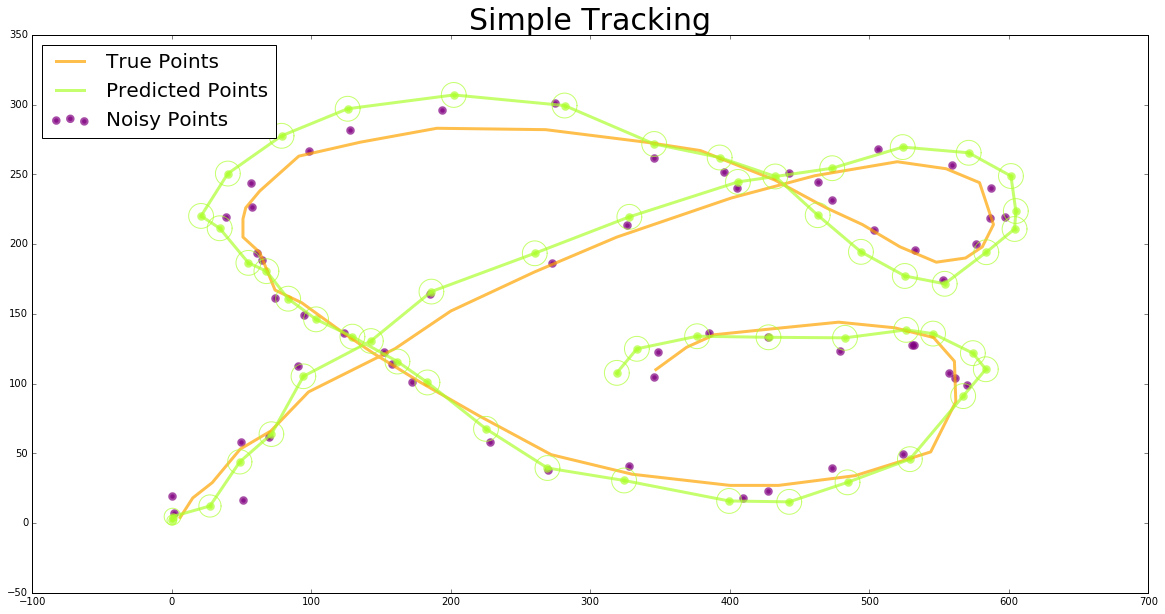

In [196]:
simple_tracking.Plot("Simple Tracking", observations, predictions, [-100, 700], [-50,350], true_data)

In [197]:
tmp = scipy.io.loadmat('ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template

data = []
for i in range( 0, frames.shape[1] ):
    tmp = numpy.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = numpy.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results

observations = numpy.asarray( data )
    
ball_tracking = Main(observations)
predictions = ball_tracking.Run()



  VisibleDeprecationWarning)



# I left the same initial parameters from the simple tracker

I could not make pyplot to animate/redraw one single image so I just showed all the images

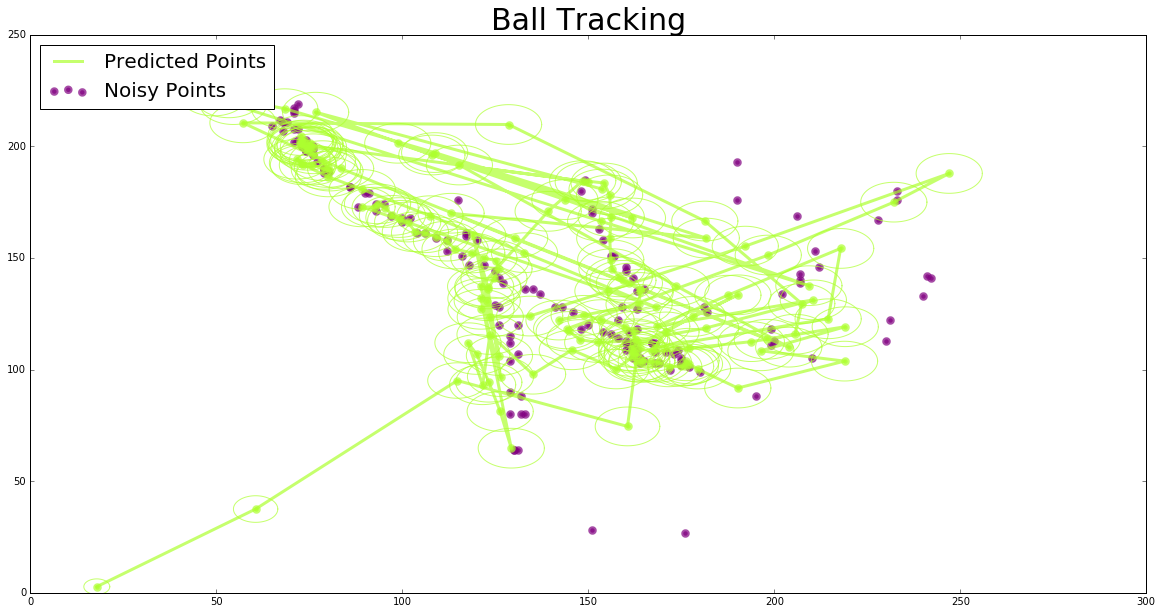

In [198]:
ball_tracking.Plot("Ball Tracking", observations, predictions, [0, 300], [0,250])

<class 'matplotlib.collections.PathCollection'>


AttributeError: 'PathCollection' object has no attribute 'set_data'

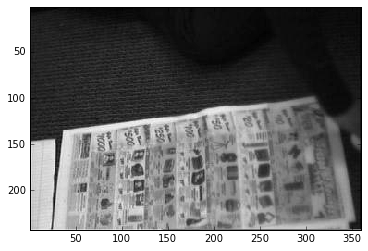

In [199]:
ball_tracking.Movie(observations, predictions, frames)

<img src="tempImage.gif">